# Assembly name prediction

## Simple baseline with BERT and cosine similarity

In [96]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from tqdm import tqdm
from collections import Counter
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from numpy.linalg import norm
from transformers import BertTokenizer, TFBertModel, DataCollatorForLanguageModeling
import seaborn as sns
from sklearn.metrics import top_k_accuracy_score as top_k

### Pre-process data for task

In [97]:
data_path = "data/data_02.feather"
data = pd.read_feather(data_path)

In [98]:
data = data.dropna(subset=["assembly_name", "part_names"])
data = data.drop(columns=["assembly_id", 'assembly_description'])
data.head()

,assembly_name,part_names
0,Lava Lamp 2,"[Blob3, Blob2, Blob1, Glass, Cap]"
1,Sample - Headphones,"[Pivot hinge, Headphone hinge, Telescope hinge..."
4,Coffee Mug,"[Mug, Lid]"
5,Dave's Handsome Mug,"[Lid, Seal, Vessel]"
9,Mechanical Pencil,"[Eraser, Pencil Lead, Rubber Grip, Gripper Rod..."


In [99]:
# Deduplicate
print(f"Tot: {len(data)}")
print(f"Unique: {len(data['assembly_name'].unique())}")
data = data[~data['part_names'].apply(tuple).duplicated()]
print(f"\nAfter dedup: {len(data)}")
print(f"Unique: {len(data['assembly_name'].unique())}")

Tot: 88886
Unique: 67834

After dedup: 61725
Unique: 54034


### Clean assembly names

In [100]:
def process_assembly_names(string):
    string = string.replace('.x_t', '')
    string = string.replace('.stp', '')
    string = string.replace('.step', '')
    string = string.replace('.zip', '')
    string = ' '.join(re.findall('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', string))  # splits camelCase into camel case
    string = ' '.join(re.split('(\s+|^)([A-Za-z]+)\d+(\s+|$)', string))  # removes number at the end
    string = string.lower()
    string = string.replace('_', ' ')
    string = string.replace('-', ' ')
    string = string.replace('[', ' ')
    string = string.replace(']', ' ')
    string = string.replace('(', ' ')
    string = string.replace(')', ' ')
    string = string.replace('?', ' ')
    string = string.replace('*', ' ')
    string = string.replace('copy of', ' ')
    string = string.replace('copy', ' ')
    string = " ".join(string.split())

    return string


data['assembly_name_clean'] = data.apply(lambda row: process_assembly_names(row.assembly_name), axis=1)

In [101]:
print(f"After dedup: {len(data)}")
print(f"Unique: {len(data['assembly_name_clean'].unique())}")

After dedup: 61725
Unique: 49601


### Clean part names

In [102]:
def process_part_names(list):
    part_names = []
    for string in list:
        if "MANIFOLD_SOLID_BREP" in string:
            return np.nan
        string = string.replace('.x_t', '')
        string = string.replace('.stp', '')
        string = string.replace('.step', '')
        string = string.replace('.dwg', '')
        string = string.replace('.zip', '')
        string = ' '.join(re.findall('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', string))  # splits camelCase into camel case
        string = ' '.join(re.split('(\s+|^)([A-Za-z]+)\d+(\s+|$)', string))  # removes number at the end
        string = string.lower()
        string = string.replace('_', ' ')
        string = string.replace('-', ' ')
        string = string.replace('[', ' ')
        string = string.replace(']', ' ')
        string = string.replace('(', ' ')
        string = string.replace(')', ' ')
        string = string.replace('?', ' ')
        string = string.replace('*', ' ')
        string = string.replace('copy of', ' ')
        string = string.replace('copy', ' ')
        string = " ".join(string.split())

        part_names.append(string)

    return part_names


data['part_names_clean'] = data.apply(lambda row: process_part_names(row.part_names), axis=1)
data.dropna(subset=['part_names_clean'], inplace=True)


In [103]:
data.head()

,assembly_name,part_names,assembly_name_clean,part_names_clean
0,Lava Lamp 2,"[Blob3, Blob2, Blob1, Glass, Cap]",lava lamp 2,"[blob, blob, blob, glass, cap]"
1,Sample - Headphones,"[Pivot hinge, Headphone hinge, Telescope hinge...",sample headphones,"[pivot hinge, headphone hinge, telescope hinge..."
4,Coffee Mug,"[Mug, Lid]",coffee mug,"[mug, lid]"
5,Dave's Handsome Mug,"[Lid, Seal, Vessel]",dave's handsome mug,"[lid, seal, vessel]"
9,Mechanical Pencil,"[Eraser, Pencil Lead, Rubber Grip, Gripper Rod...",mechanical pencil,"[eraser, pencil lead, rubber grip, gripper rod..."


### Create sentences for BERT

In [104]:
def create_sentences(data_df, deduplicate_part_names=True):
    part_name_sentences = []
    assembly_name_sentences = []

    for index, row in tqdm(data_df.iterrows(), total=len(data_df)):
        # if len(row['part_names_clean']) > 1:
        # build single part name sentence
        part_name_sentence = "An assembly containing the following parts: "
        if deduplicate_part_names:
            part_names = set(row['part_names_clean'])
        else:
            part_names = row['part_names_clean']
        for part_name in part_names:
            part_name_sentence +=  f"{part_name}, "
        part_name_sentence = part_name_sentence[:-2] + "."
        part_name_sentences.append(part_name_sentence)

        # build single assembly name sentence
        assembly_name_sentence = f"An assembly with the name '{row['assembly_name_clean']}'"
        assembly_name_sentences.append(assembly_name_sentence)
    return part_name_sentences, assembly_name_sentences

In [105]:
part_name_sentences, assembly_name_sentences = create_sentences(data)

100%|██████████| 61601/61601 [00:03<00:00, 18082.90it/s]


In [106]:
print(len(part_name_sentences))
part_name_sentences[:10]

61601


['An assembly containing the following parts: glass, blob, cap.',
 'An assembly containing the following parts: pivot hinge, headphone hinge, upper band, headphone speaker, telescope hinge.',
 'An assembly containing the following parts: mug, lid.',
 'An assembly containing the following parts: lid, vessel, seal.',
 'An assembly containing the following parts: button release, lead gripper, eraser, rubber grip, pencil lead, gripper rod.',
 'An assembly containing the following parts: link, peg, plate, block, wheel.',
 'An assembly containing the following parts: head, default, torch holder, b18.3.5m 4 x 0.7 x 10 socket fchs 10s.',
 'An assembly containing the following parts: cap, bottle base.',
 'An assembly containing the following parts: symmetry of clips, t x2 00e9 x0 sup x2 00e9 x0 rieur bis, symmetry of chape roulement, arm support, t x2 00e9 x0 inf x2 00e9 x0 rieur, motor, axe amorto rotatif, supports levier, rouleau, human thigh, symmetry of axes molette levier, symmetry of corp

In [107]:
print(len(assembly_name_sentences))
assembly_name_sentences[:10]

61601


["An assembly with the name 'lava lamp 2'",
 "An assembly with the name 'sample headphones'",
 "An assembly with the name 'coffee mug'",
 "An assembly with the name 'dave's handsome mug'",
 "An assembly with the name 'mechanical pencil'",
 "An assembly with the name 'os kinematics'",
 "An assembly with the name 'torch light for bike'",
 "An assembly with the name 'bottle'",
 "An assembly with the name 'concept vehicle'",
 "An assembly with the name 'mounting arm'"]

### Train test split

In [108]:
train_strings, test_strings, train_labels, test_labels = train_test_split(part_name_sentences,assembly_name_sentences, test_size=0.2, random_state=0)
print(f"Length of train strings: {len(train_strings)}")
print(f"Length of test strings: {len(test_strings)}")
print(f"Length of train labels: {len(train_labels)}")
print(f"Length of test labels: {len(test_labels)}")

Length of train strings: 49280
Length of test strings: 12321
Length of train labels: 49280
Length of test labels: 12321


### Tokenize and create embeddings

In [109]:
model_checkpoint = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [110]:
def create_embeddings(strings, labels, tokenizer, model, max_length=128, batch_size=100, pooling='cls'):

    test_strings_embeddings_batched, test_labels_embeddings_batched = [], []
    num_batches = len(strings)//batch_size
    for batch in tqdm(range(num_batches), total=num_batches):
        test_strings_token = tokenizer(strings[batch*batch_size:(batch+1)*batch_size],
                      max_length=max_length,
                      truncation=True,
                      padding=True,
                      return_tensors='tf')

        test_labels_tokens = tokenizer(labels[batch*batch_size:(batch+1)*batch_size],
                      max_length=max_length,
                      truncation=True,
                      padding=True,
                      return_tensors='tf')

        test_strings_embeddings = model(test_strings_token)
        test_labels_embeddings = model(test_labels_tokens)

        if pooling == 'cls':
            test_strings_embeddings = test_strings_embeddings[0][:, 0, :]
            test_labels_embeddings = test_labels_embeddings[0][:, 0, :]
        else:
            test_strings_embeddings = test_strings_embeddings[1]
            test_labels_embeddings = test_labels_embeddings[1]
        test_strings_embeddings_batched.append(test_strings_embeddings)
        test_labels_embeddings_batched.append(test_labels_embeddings)

    return test_strings_embeddings_batched, test_labels_embeddings_batched

In [134]:
test_strings_embeddings, test_labels_embeddings = create_embeddings(test_strings, test_labels, bert_tokenizer, bert_model)

100%|██████████| 123/123 [01:39<00:00,  1.24it/s]


### Evaluate with cosine similarity and argmax

In [112]:
def evaluate_similarity(test_strings_embeddings_batches, test_labels_embeddings_batches):
    similarity_batches = []
    for batch_id in range(len(test_strings_embeddings_batches)):
        test_strings_embeddings = tf.nn.l2_normalize(test_strings_embeddings_batches[batch_id], 0)
        test_labels_embeddings = tf.nn.l2_normalize(test_labels_embeddings_batches[batch_id], 0)

        similarity = test_strings_embeddings @ tf.transpose(test_labels_embeddings)
        similarity_batches.append(similarity)

    return similarity_batches



In [135]:
similarity_batches = evaluate_similarity(test_strings_embeddings, test_labels_embeddings)

[Text(0.5, 47.24444444444444, 'Part Names'),
 Text(74.44444444444444, 0.5, 'Assembly Names'),
 Text(0.5, 1.0, 'Cosine Similarity Between Assembly Names and Part Names')]

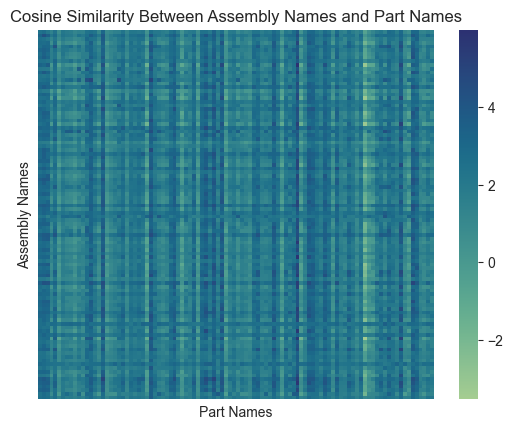

In [136]:
ax = sns.heatmap(similarity_batches[0], cmap="crest", xticklabels=False, yticklabels=False) #, annot=True)
ax.set(xlabel="Part Names", ylabel="Assembly Names", title="Cosine Similarity Between Assembly Names and Part Names")

In [137]:
pred = []
true = []
for index, value in enumerate(similarity_batches[0][:10]):
    predicted = np.argmax(value)
    actual = index
    pred.append(predicted)
    true.append(actual)
    print(f"Predicted: {predicted} | Actual: {index}")

Predicted: 65 | Actual: 0
Predicted: 65 | Actual: 1
Predicted: 65 | Actual: 2
Predicted: 65 | Actual: 3
Predicted: 91 | Actual: 4
Predicted: 28 | Actual: 5
Predicted: 94 | Actual: 6
Predicted: 65 | Actual: 7
Predicted: 65 | Actual: 8
Predicted: 65 | Actual: 9


In [138]:
def evaluate_accuracy(similarity_batches):
    top_ks = [1,5,10]
    for k in top_ks:
        tot_accuracy = []
        for batch in similarity_batches:
            top_k_values = np.argsort(-batch, axis=1)[:,:k]
            correct = 0
            for index, row in enumerate(top_k_values):
                if index in row:
                    correct += 1
            accuracy = correct / len(batch)
            tot_accuracy.append(accuracy)


        print(f"Top-{k} accuracy: {np.mean(tot_accuracy)}")

In [139]:
evaluate_accuracy(similarity_batches)

Top-1 accuracy: 0.056829268292682936
Top-5 accuracy: 0.15682926829268293
Top-10 accuracy: 0.2378048780487805


## Fine-tuned BERT

### Load test data

In [ ]:
test_data = pd.read_csv('data/test.csv')

In [ ]:
test_strings, test_labels = create_sentences(data.loc[test_data['Unnamed: 0'].tolist()])

In [ ]:
test_strings[:5]

In [ ]:
test_labels[:5]

In [124]:
test_data = pd.read_csv('data/test.csv')

In [125]:
test_strings, test_labels = create_sentences(data.loc[test_data['Unnamed: 0'].tolist()])

100%|██████████| 12321/12321 [00:00<00:00, 18441.83it/s]


In [126]:
test_strings[:5]

['An assembly containing the following parts: side 2, side 1, end 2, end 1, short divider, long divider.',
 'An assembly containing the following parts: 20mm stack.',
 'An assembly containing the following parts: basetopkey, basebottomkeyhalf, boxlid, windholder, basebottomkeyotherhalf, internalcomb, mainbox, barform.',
 'An assembly containing the following parts: hub build plate prt12, component, l 2112kk cage, bl touch, nut driver prt3, fake support, 177, wheel b1, pivot pin, carriage mount 2 prt10, 168, 166, 159, extruder grove wheel\\x2\\00d8\\x0\\13, boden frame, motor shaft, carrage mount prt8, heater, microswitch 1a 125v ac seul, 165, plate mount prt9, z screw, pin\\x2\\00d8\\x0\\5, turbine, 175, 147, shaft top prt4, stepper prt1, 184, l 2112kk ball, spacer 5x10x6.35, 157, pcb^endstop, aluminum spacer 20mm, heatsink^e3d nozzle v, 5972k154, 152, main body, extruder body alumium, heater block^e3d nozzle v, solid, 182, vt1m3x30, 144, carrage prt6, open rail gantry plate 60mm, arm,

In [127]:
test_labels[:5]

["An assembly with the name 'box shell version'",
 "An assembly with the name '20mm stack'",
 "An assembly with the name 'ww sport base bar box'",
 "An assembly with the name 'circle builder'",
 "An assembly with the name '2238 375.step'"]

### Load fine-tuned model from checkpoint and get embeddings

In [128]:
checkpoint_dir = 'MLM/fine_tuning/bert_fine_tuned_2'
bert_tokenizer_2 = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model_2 = TFBertModel.from_pretrained(checkpoint_dir)

Some layers from the model checkpoint at MLM/fine_tuning/bert_fine_tuned_2 were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at MLM/fine_tuning/bert_fine_tuned_2 and are newly initialized: ['bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [129]:
test_strings_embeddings, test_labels_embeddings = create_embeddings(test_strings, test_labels, bert_tokenizer_2, bert_model_2)

100%|██████████| 123/123 [01:37<00:00,  1.26it/s]


### Evaluate

In [130]:
similarity_batches = evaluate_similarity(test_strings_embeddings, test_labels_embeddings)

[Text(0.5, 47.24444444444444, 'Part Names'),
 Text(74.44444444444444, 0.5, 'Assembly Names'),
 Text(0.5, 1.0, 'Cosine Similarity Between Assembly Names and Part Names')]

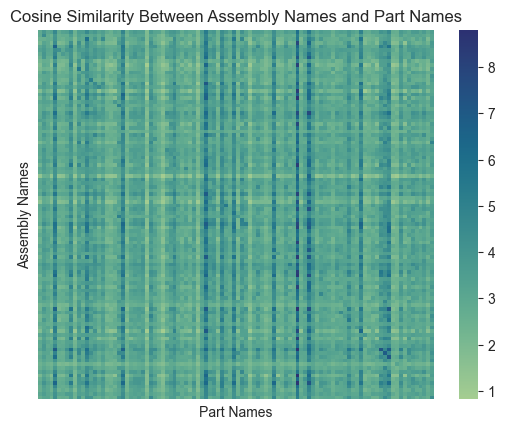

In [131]:
ax = sns.heatmap(similarity_batches[0], cmap="crest", xticklabels=False, yticklabels=False) #, annot=True)
ax.set(xlabel="Part Names", ylabel="Assembly Names", title="Cosine Similarity Between Assembly Names and Part Names")

In [132]:
for index, value in enumerate(similarity_batches[0][:10]):
    predicted = np.argmax(value)
    actual = index
    print(f"Predicted: {predicted} | Actual: {index}")

Predicted: 65 | Actual: 0
Predicted: 65 | Actual: 1
Predicted: 12 | Actual: 2
Predicted: 65 | Actual: 3
Predicted: 4 | Actual: 4
Predicted: 65 | Actual: 5
Predicted: 65 | Actual: 6
Predicted: 65 | Actual: 7
Predicted: 65 | Actual: 8
Predicted: 65 | Actual: 9


In [133]:
evaluate_accuracy(similarity_batches)

Top-1 accuracy: 0.09495934959349595
Top-5 accuracy: 0.20813008130081304
Top-10 accuracy: 0.30308943089430895
